In [1]:
%pylab inline
import seaborn as sbn
import networkx as nx
import pickle
import scipy as sp
import scipy.stats
from scipy.optimize import curve_fit
import glob
import os
from Bio.PDB import *
from MDAnalysis import *
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [ ]:
def get_pdb_data_for_given_length_range(pdb_files, lower_bound, upper_bound, verbose=False):   
    t = 8.0
    linklengths = []
    pdb_count = 0
    sim_data_hist = None
    sim_data_edges = None
    for pdb in pdb_files:
        u = Universe(pdb)
        calphas = u.select_atoms("name CA and segid " + u.residues.segments.segids[0])
        if verbose:
            print(len(calphas))
        if lower_bound <= len(calphas) <= upper_bound:
            r = calphas.positions
            maxdist = 0
            G = nx.empty_graph(len(r))
            avd = 0
            for i in range(len(r)):
                for j in range(i):
                    dist = np.linalg.norm(r[i] - r[j])
                    maxdist = max(dist, maxdist)
                    avd += dist ** 2
                    if dist < t:
                        G.add_edge(i, j)
                        linklengths.append(dist)
            avd = np.sqrt(avd) / (len(r))
            # take largest component
            if len(G.edges()) > 0:
                G = list(connected_component_subgraphs(G))[0]
                lena = len(G.nodes())
                Li = list(set(G.edges()) - set(nx.cycle_graph(lena).edges()))
                link_length_list = []
                for link in Li:
                    link_length_list.append(abs(link[0] - link[1]))
                sim_data_hist, sim_data_edges = np.histogram(link_length_list, bins=range(3, 1000), normed=True)
            pdb_count +=1
    if sim_data_hist is not None:
        sim_data_hist = sim_data_hist/pdb_count
    return sim_data_hist, sim_data_edges

In [28]:
def do_analysis(calphas, link_length_list, t=8.0):
    linklengths = []
    r = calphas.positions
    maxdist = 0
    G = nx.empty_graph(len(r))
    avd = 0
    for i in range(len(r)):
        for j in range(i):
            dist = np.linalg.norm(r[i] - r[j])
            maxdist = max(dist, maxdist)
            avd += dist ** 2
            if dist < t:
                G.add_edge(i, j)
                linklengths.append(dist)
    avd = np.sqrt(avd) / (len(r))
    # take largest component
    if len(G.edges()) > 0:
        G = list(connected_component_subgraphs(G))[0]
        lena = len(G.nodes())
        Li = list(set(G.edges()) - set(nx.cycle_graph(lena).edges()))
        for link in Li:
            #return(abs(link[0]-link[1]))
            link_length_list.append(abs(link[0] - link[1]))

In [34]:
import urllib
import pandas as pd
query = pd.read_csv('../data/mix.txt')


In [35]:
query.columns

Index(['3UQI', '3V2L', '3V2B', '3UPV', '3V1O', '3V1Q', '3V1R', '3UPS', '3V3L',
       '3URC', '3V2G', '3V2I', '3V2J', '3V2K', '3V2M', '3V2N', '3UQA', '3UQB',
       '3V1N', '3UQ3', '3V3H', '3V3I', '3UQH', '3UQ8', '3V1W', '3UQ0', '3UPQ',
       '3UQ2', '3URI', '3URJ', '3URL', '3V3M', '3URE', '3URF', '3V38', '3UR9',
       '3V1V', '3UPW', '3UPX', '3V1X', '3UPZ', '3V1P', '3V1U', '3UQW', '3UQX',
       '3V39', '3UQP', '3V33', '3UQU', '3V4J'],
      dtype='object')

In [36]:
hundred = []
twohundered = []
threehundred = []
fourhundred = []
ll_100 = []
ll_200 = []
ll_300 = []
ll_400 = []
for pdb in query.columns:
    #print (pdb)
    download = 'https://files.rcsb.org/download/%s.pdb' %pdb
    #print(download)
    file_name = '../data/temp/'+pdb+'.pdb'
    urllib.request.urlretrieve(download, file_name)
    u = Universe(file_name)
    calphas = u.select_atoms("name CA and segid " + u.residues.segments.segids[0])
    chain_len = len(calphas)
    print(chain_len)
    if chain_len in range(85,115):
        hundred.append(pdb)
        do_analysis(calphas, ll_100)
        #print(len(ll_100))
    if chain_len in range(185,215):
        twohundered.append(pdb)
        do_analysis(calphas, ll_200)
    if chain_len in range(285,315):
        threehundred.append(pdb)
        do_analysis(calphas, ll_300)
    if chain_len in range(385,415):
        fourhundred.append(pdb)
        do_analysis(calphas, ll_400)
    os.remove(file_name)
# data for length 100
sim_data_hist_100, sim_data_edges = np.histogram(ll_100, bins=range(3, 1000), normed=True)
sim_data_hist_100 = sim_data_hist_100/len(hundred)
np.save('simdata_hist_100.npy', sim_data_hist_100)

# data for length 200
sim_data_hist_200, sim_data_edges = np.histogram(ll_200, bins=range(3, 1000), normed=True)
sim_data_hist_200 = sim_data_hist_200/len(hundred)
np.save('simdata_hist_200.npy', sim_data_hist_200)

# data for length 300
sim_data_hist_300, sim_data_edges = np.histogram(ll_300, bins=range(3, 1000), normed=True)
sim_data_hist_300 = sim_data_hist_300/len(hundred)
np.save('simdata_hist_300.npy', sim_data_hist_300)

# data for length 400
sim_data_hist_400, sim_data_edges = np.histogram(ll_400, bins=range(3, 1000), normed=True)
sim_data_hist_400 = sim_data_hist_400/len(hundred)
np.save('simdata_hist_400.npy', sim_data_hist_400)

108
124
180
125
165
157
165
113
89
218
252
191
258
246
258
45
194
196
290
258
263
262
159
322
358
313
313
318
328
328
329
316
199
156
349
166
319
412
447
313
465
229
417
376
383
419
377
163
378
187


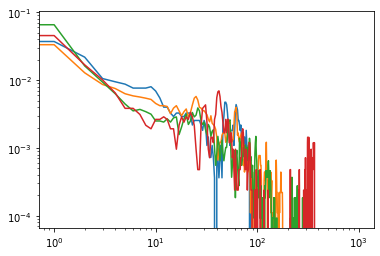

In [37]:
plot(sim_data_hist_100)
plot(sim_data_hist_200)
plot(sim_data_hist_300)
plot(sim_data_hist_400)
plt.yscale('log')
plt.xscale('log')

In [38]:
np.save('simdata_hist_100.npy', sim_data_hist_100)

In [48]:
np.save('300_Ids.npy',threehundred)

In [41]:
hundred

['3UQI', '3UPS', '3V3L']

In [42]:
twohundered

['3V2I', '3UQA', '3UQB', '3URE', '3V4J']

In [43]:
fourhundred

['3UPW']

In [47]:
len(query.columns)

50